In [1]:
import altair as alt
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [3]:
status_files = glob.iglob('../pune_samples/case_status/*.csv')
dataframes = [pd.read_csv(f, index_col='Filing Date', parse_dates=True) for f in status_files]
df = pd.concat(dataframes, sort=False)

In [4]:
# column formatting
to_category = ['Case Type', 'Stage of Case', 'Under Act(s)', 'Judge',
               'Court Number', 'Under Section(s)', 'Nature of Disposal']
df[to_category] = df[to_category].astype('category')
to_date = ['Registration Date', 'First Hearing Date', 'Last Hearing Date',
           'Transfer Date', 'Next Hearing Date', 'Decision Date', 'sub_court_DecisionDate']
df[to_date] = df[to_date].apply(pd.to_datetime, errors='coerce')

In [5]:
disposed_cases = df[df['Decision Date'].notnull()]
decision_days = (disposed_cases['Decision Date'] - disposed_cases['First Hearing Date']).dt.days
days_frequency_df = pd.DataFrame(decision_days.value_counts(), columns=['no of cases'])
days_frequency_df.index.name = 'days'
days_frequency_df = days_frequency_df.reset_index()

In [6]:
def mapper(days):
    if days > 365:
        return '> 1 Year'
    if days > 270 and days < 365:
        return '9-12 Months'
    if days > 180 and days < 270:
        return '6-9 Months'
    if days > 90 and days < 180:
        return '3-6 Months'
    if days > 30 and days < 90:
        return '1-3 Months'
    if days > 7 and days < 30:
        return '< 1 Month'
    if days > 0 and days < 7:
        return '<1 Week'
    if days == 0:
        return 'Instant'

In [7]:
days_frequency_df.days = days_frequency_df.days.apply(mapper)
grouped = days_frequency_df.groupby('days', as_index=False).sum().sort_values(by='no of cases', ascending=True)
grouped = grouped.reset_index()

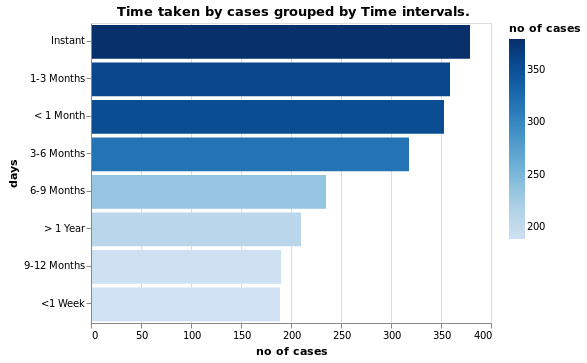

In [8]:
alt.Chart(grouped, height=300, width=400).mark_bar().encode(
    y=alt.Y('days', sort=alt.EncodingSortField(field='no of cases', op='sum', order='descending')),
    x=alt.X('no of cases'),
    color=alt.Color('no of cases')
).properties(
    title='Time taken by cases grouped by Time intervals.'
)

In [9]:
disposed_cases['decision_days'] = decision_days
data = disposed_cases.reset_index()

/root/.local/share/virtualenvs/cdl-trial-project-Nfr47BZG/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


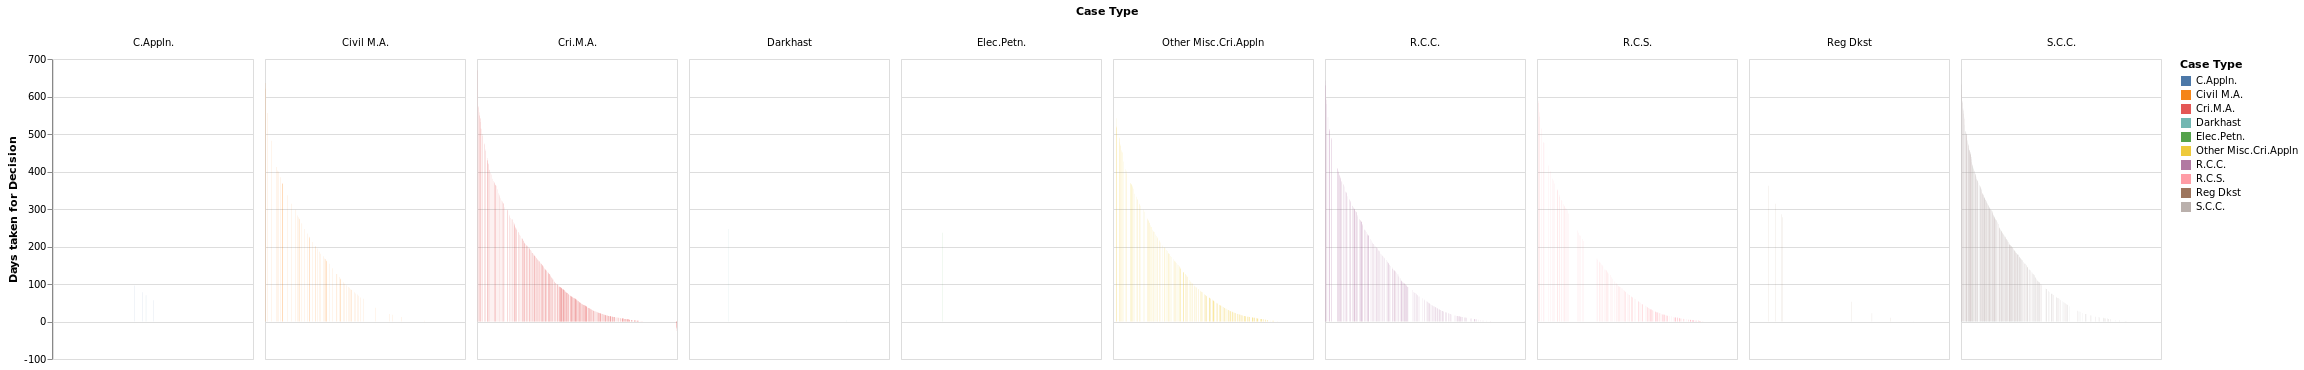

In [19]:
alt.Chart(disposed_cases, height=300, width=200).mark_bar().encode(
    x=alt.X('CNR Number', axis=None, sort=alt.EncodingSortField(field='decision_days', op='sum', order='descending')),
    y=alt.Y('decision_days', axis=alt.Axis(title='Days taken for Decision')),
    column=alt.Column('Case Type'),
    color=alt.Color('Case Type')
)